# Machine Learning Approach to Estimating Photometric Redshifts for AGN

In this notebook I load and train a data set of ~900 galaxies with X-ray luminous AGN in order to estimate photometric redshifts using a machine learning approach. Photometric redshifts for galaxies are typically estimated through spectral energy distribution (SED) fitting methods (see http://sedfitting.org/Welcome.html) and yield far poorer quality redshifts than those obtained from spectroscopy, especially in the case of AGN. However, photo-zs are often necessary for large surveys as obtaining spectroscopic redshifts can be time-consuming and computationally expensive. The goal of this project is to improve photometric redshift estimates over those yielded from current SED fitting methods implemented in studies such as [Ananna et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...66A/abstract).

All data in this notebook are taken from the NEWFIRM K-selected SHELA catalog (see [Stevans et al. 2020](https://ui.adsabs.harvard.edu/abs/2021arXiv210314690S/abstract)) and Stripe 82X catalog (see [Lamassa et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...817..172L/abstract)).

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Load the training set

df = pd.read_csv('train.csv')

df.head()

,Unnamed: 0,ID,specz,u_flux,u_err,g_flux,g_err,r_flux,r_err,i_flux,...,JUV_flux,JUV_err,KUV_flux,KUV_err,K_flux,K_err,ch1_flux,ch1_err,ch2_flux,ch2_err
0,0,23351,2.760316,0.014086,0.000955,0.027036,0.001719,0.038791,0.001342,0.038834,...,0.046001,0.004392,0.047536,0.004399,0.037667,0.002026,0.066798,0.003613,0.097507,0.005337
1,1,20537,2.747530,0.037558,0.001232,0.053658,0.001746,0.067047,0.002196,0.067760,...,0.082113,0.004346,0.070553,0.004394,0.076923,0.000982,0.087584,0.004526,0.131902,0.006359
2,2,2293,2.154657,0.122013,0.003937,0.111283,0.003596,0.119048,0.003853,0.127056,...,0.099441,0.004249,0.131890,0.004045,0.141504,0.001254,0.152524,0.007173,0.225258,0.010495
3,3,5133,1.870031,0.001211,0.000133,0.002087,0.000096,0.003256,0.000279,0.005732,...,0.010719,0.003264,0.019743,0.003876,0.021568,0.000898,0.039198,0.002013,0.055351,0.002972
4,4,25545,0.561281,0.002869,0.000171,0.005627,0.000319,0.015944,0.000616,0.029162,...,0.074113,0.004381,0.118645,0.004128,0.108776,0.001359,0.153691,0.007196,0.096539,0.004812


In [147]:
# Select only rows with a spectroscopic redshift and see target variable (specz) statistics:

df.where(df.specz > 0, inplace=True)
df.dropna(inplace=True)

df.specz.describe()

count    855.000000
mean       1.120258
std        0.717911
min        0.028552
25%        0.542063
50%        0.986655
75%        1.554531
max        5.391201
Name: specz, dtype: float64

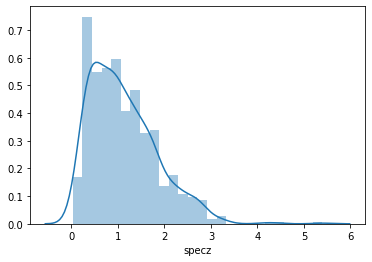

In [148]:
sns.distplot(df['specz'])

In [149]:
# Define sigma_NMAD which we will use after we estimate a redshift

def sigma_nmad(delta_z, specz):
    s = 1.48 * np.median(np.abs((delta_z - np.median(delta_z)) / 
                                (1. + np.median(specz) ) ))
    return s


Now we will create new features to train the model, such as magnitudes, color, etc.

In [150]:
# Convert all fluxes to magnitudes, make color combinations which reveal something about shape of spectra

def flux_to_mag(flux):
    mag = -2.5 * np.log10(flux) + 16.4
    return mag

df['u_mag'] = flux_to_mag(df['u_flux'])
df['g_mag'] = flux_to_mag(df['g_flux'])
df['r_mag'] = flux_to_mag(df['r_flux'])
df['i_mag'] = flux_to_mag(df['i_flux'])
df['z_mag'] = flux_to_mag(df['z_flux'])
df['K_mag'] = flux_to_mag(df['K_flux'])
df['ch1_mag'] = flux_to_mag(df['ch1_flux'])
df['ch2_mag'] = flux_to_mag(df['ch2_flux'])

# Make several different color combinations

df['u_r'] = df['u_mag'] - df['r_mag']
df['g_i'] = df['g_mag'] - df['i_mag']
df['g_z'] = df['g_mag'] - df['z_mag']
df['g_K'] = df['g_mag'] - df['K_mag']
df['r_i'] = df['r_mag'] - df['i_mag']
df['r_K'] = df['r_mag'] - df['K_mag']
df['ch1_ch2'] = df['ch1_mag'] - df['ch2_mag']

# Define Signal-to-noise ratios

df['u_SNR'] = df['u_flux'] / df['u_err']
df['g_SNR'] = df['g_flux'] / df['g_err']
df['r_SNR'] = df['r_flux'] / df['r_err']
df['i_SNR'] = df['i_flux'] / df['i_err']
df['z_SNR'] = df['z_flux'] / df['z_err']
df['K_SNR'] = df['K_flux'] / df['K_err']
df['ch1_SNR'] = df['ch1_flux'] / df['ch1_err']
df['ch2_SNR'] = df['ch2_flux'] / df['ch2_err']

# Calculate total flux from new dataframe:

def ret_zero(flux):
    new_flux = flux.where(flux != -99, 0)
    return new_flux

wavelengths = [0.38566, 0.482, 0.6423, 0.78067, 0.91585, 1.25, 2.15, 2.17, 3.5569, 4.5]

c = 3.00e8

freq = [c / (wavelengths[x] * 1e-6) for x in range(len(wavelengths))]

df['total_flux'] = np.log10(ret_zero(df.u_flux) * freq[0] + ret_zero(df.g_flux) * freq[1] + ret_zero(df.r_flux) * freq[2] + \
                   ret_zero(df.i_flux) * freq[3] + ret_zero(df.z_flux) * freq[4] + ret_zero(df.K_flux) * freq[5] + \
                   ret_zero(df.ch1_flux) * freq[6] + ret_zero(df.ch2_flux) * freq[7])

df.fillna(0)

/Users/jonathanflorez/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0,ID,specz,u_flux,u_err,g_flux,g_err,r_flux,r_err,i_flux,...,ch1_ch2,u_SNR,g_SNR,r_SNR,i_SNR,z_SNR,K_SNR,ch1_SNR,ch2_SNR,total_flux
0,0.0,23351.0,2.760316,0.014086,0.000955,0.027036,0.001719,0.038791,0.001342,0.038834,...,0.410687,14.750287,15.724616,28.903997,28.134901,24.361577,18.594852,18.490649,18.269992,14.026292
1,1.0,20537.0,2.747530,0.037558,0.001232,0.053658,0.001746,0.067047,0.002196,0.067760,...,0.444560,30.479638,30.734378,30.524738,30.325923,29.610942,78.361523,19.349847,20.742842,14.287143
2,2.0,2293.0,2.154657,0.122013,0.003937,0.111283,0.003596,0.119048,0.003853,0.127056,...,0.423356,30.989838,30.949929,30.899851,30.913561,30.740900,112.877689,21.264595,21.462421,14.602891
3,3.0,5133.0,1.870031,0.001211,0.000133,0.002087,0.000096,0.003256,0.000279,0.005732,...,0.374646,9.085163,21.830095,11.662646,13.394509,9.146979,24.028893,19.475818,18.621374,13.420905
4,4.0,25545.0,0.561281,0.002869,0.000171,0.005627,0.000319,0.015944,0.000616,0.029162,...,-0.504861,16.785755,17.630224,25.881168,26.320903,22.930430,80.069791,21.356768,20.062412,13.987793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,956.0,664755.0,1.834910,0.003852,0.000196,0.005494,0.000487,0.005726,0.000434,0.010647,...,0.305034,19.637765,11.276503,13.207304,7.286622,12.209188,17.701420,17.363642,18.532291,13.540100
957,957.0,838786.0,0.919000,0.005284,0.000215,0.010346,0.000345,0.017698,0.000691,0.023402,...,0.178655,24.552981,29.972214,25.614570,21.703570,25.091830,66.847125,20.996530,21.276691,14.010261
959,959.0,303089.0,0.457292,0.006186,0.000206,0.010956,0.000361,0.018897,0.000617,0.062520,...,0.190038,30.062994,30.359045,30.639742,22.384996,27.584957,118.849889,21.130115,21.335226,14.287153
961,961.0,801745.0,0.028552,0.069677,0.002338,0.139354,0.004545,0.213577,0.007022,0.262785,...,-0.171572,29.805735,30.661124,30.414752,30.391781,28.878848,52.159064,18.222794,16.916024,14.731666


In [151]:
# Select features

features = ['u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag', 'K_mag', 'ch1_mag', 'ch2_mag', 
            'u_SNR', 'g_SNR', 'r_SNR', 'i_SNR', 'z_SNR', 'K_SNR', 'ch1_SNR', 'ch2_SNR',
            'u_r', 'g_i', 'g_z', 'g_K', 'r_i', 'r_K', 'ch1_ch2']

# Make training and validation sets

X = df[features]
y = df.specz

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,random_state=0)
ind = y_val.index.values

In [152]:
model = XGBRegressor(n_estimators=600,learning_rate=0.05)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=4,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [153]:
ML_z = model.predict(X_val)
print("Mean Absolute Error from ML: " + str(mean_absolute_error(ML_z, y_val)))

Mean Absolute Error from ML: 0.17533977734054232


(0, 3.5)

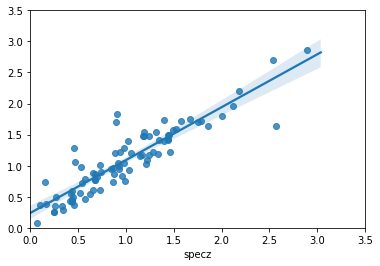

In [154]:
sns.regplot(x=y_val, y=ML_z)
plt.xlim(0,3.5)
plt.ylim(0,3.5)

In [155]:
delta_z = (ML_z - y_val)

print(sigma_nmad(delta_z, y_val))

0.08801907113004508
